In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import sys
sys.path.append("../src/")
from mixae import mixae_model, entropy_callback, probabilities_log
from batchmanager import BatchManager
import data_loader as dl

Using TensorFlow backend.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
from sklearn.utils.fixes import comb

In [4]:
def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Requires scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    copied from: https://github.com/XifengGuo/DCEC/blob/master/metrics.py
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

def plot_confusion_matrix(
        validation_targets,
        predicted_values,                      
        title = "",
        true_cols = None,
        ax = None 
        ):
    cm_int= confusion_matrix(validation_targets, predicted_values)
    
    if type(ax) == type(None):
        fig, ax = plt.subplots()
    
    ax.set_title(title, fontsize=20)
    sns.heatmap(cm_int, annot = True, ax = ax)
    if not true_cols is None:
        ax.set_yticklabels(true_cols)
    ax.set_ylabel('True label', fontsize=14)
    ax.set_xlabel('Predicted label', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if type(ax) == type(None):
        return fig, ax 


def display_events(model, n, n_display=3, what_class=0,):
    if what_class == 0:
        event = "Proton"  
    elif what_class == 1:
        event = "Carbon"
    else:
        event = "Other" 
    all_class = np.argwhere(y_lab == what_class)
    which_class = [int(all_class[i]) for i in range(n_display)]
    print(which_class)
    pred = model.predict_on_batch(x_lab_flat[tuple(which_class), :])
    lab_samples = pred[0]
    lab_probs = pred[1]

    cmap = matplotlib.cm.magma
    cmap.set_under(color='white')

    fig, ax = plt.subplots(ncols=n_classes+1, nrows=n_display, figsize=(15, 9))
    ax[0,0].set_title(event+" events", fontsize=20)
    for i in range(n_display):
        w = which_class[i]
        ax[i][0].imshow(x_lab_flat[w].reshape(img_shape), cmap=cmap, vmin=1e-4)
        ax[i][0].axis("off")
        for j in range(n_classes):
            ax[i][j+1].imshow(lab_samples[j][i].reshape(img_shape), cmap=cmap, vmin=1e-5)
            title = r"$p_{}".format(j)
            title += r"= {:.3f}$".format(float(lab_probs[i,j]))
            ax[i][j+1].set_title(title, fontsize=14)
            ax[i][j+1].axis("off")
    base_fn = "/home/robersol/github/thesis/chapters/results/clustering/plots/"
    fn = base_fn + event + "_"+data+"_mixae_reconst_{}".format(n)
    plt.savefig(fn+".pdf")
    plt.savefig(fn+".png")
    plt.close()
    

In [ ]:
(x_full, y_tr), (x_labeled, y_lab) = tf.keras.datasets.mnist.load_data()
x_full = (np.expand_dims(x_full, -1)/255)
x_labeled = np.expand_dims(x_labeled, -1)/255
y_lab_onehot = OneHotEncoder().fit_transform(y_lab.reshape(-1, 1))
n_samples = x_full.shape[0]

/opt/conda/envs/python3.6/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


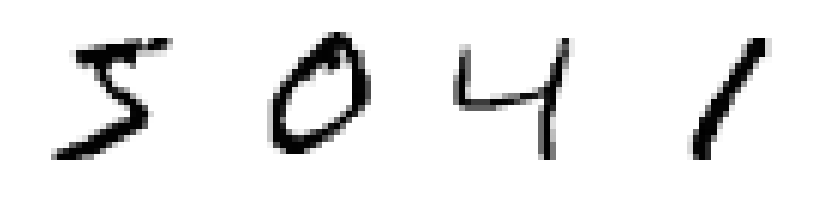

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(ncols=4, figsize=(14, 5))
og_events = [x_full[i].reshape(x_full[i].shape[0], x_full[i].shape[1]) for i in range(4)]
[axs[i].imshow(og_events[i], cmap="Greys") for i in range(4)]
[axs[i].axis("off") for i in range(4)]
plt.show()

In [ ]:
n_classes = len(np.unique(y_lab))
img_shape = x_full.shape[1:] if len(x_full.shape) == 3 else  x_full.shape[1:-1]

n_layers = 3
latent_dim = 8
kernel_architecture = [3, 3, 3]
filter_architecture = [64, 32, 16,]
strides_architecture = [2,]*n_layers
pooling_architecture = [0,]*n_layers

mode_config = {
    "simulated_mode":False, #deprecated, to be removed
    "restore_mode":False, #indicates whether to load weights 
    "include_KL":False, #whether to compute the KL loss over the latent space
    "include_MMD":False, #same as above, but MMD 
    "include_KM":False, #same as above, but K-means. See thesis for a more in-depth treatment of these
    "batchnorm":False, #whether to include batch-normalization between layers
    "use_vgg":False, #whether the input data is from a pre-trained model 
    "use_dd":False, #whether to use the dueling-decoder objective 
}

reg_strength = 1e-6
ae_args = [
    [
        n_layers,
        filter_architecture,
        kernel_architecture,
        strides_architecture,
        pooling_architecture,
        latent_dim,
        x_full.shape,
    ],
    {
        "mode_config":mode_config
    },
    [],
    {
        "kernel_reg_strength":reg_strength,
        "kernel_reg": tf.keras.regularizers.l2,
        "activation": "lrelu"
        #"output_activation": "sigmoid"
    }
]

x_full_flat = x_full.reshape(n_samples, -1)
x_lab_flat = x_labeled.reshape(x_labeled.shape[0], -1)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    "loss",
    min_delta=1e-2,
    patience=2,
    #restore_best_weights=True,
    #baseline=0.30
)

In [ ]:
x_full_flat.shape

(60000, 784)

In [ ]:
alpha = 0.005
beta = 100
theta = 10
n_clusters = 10

mix_obj = mixae_model(ae_args, alpha, beta, x_full_flat.shape[1]/theta)
m, mp, clst, _ = mix_obj.compile(n_clusters) 
pl = probabilities_log(clst, n_clusters, x_lab_flat)
ep = 0
n_eps = 100
unsuper_hist = m.fit(
    x_full_flat, 
    [
    np.expand_dims(x_full_flat, 1),
    np.zeros(n_samples),
    np.zeros(n_samples)
    ],
    batch_size=150,
    epochs=n_eps,
    initial_epoch=ep,
    callbacks=[
        #entropy_callback(mix_obj.alpha, mix_obj.beta),
        pl,
        earlystopping,
    ],
)

FINAL O (?, 28, 28, 1)
FINAL O (?, 28, 28, 1)
FINAL O (?, 28, 28, 1)
FINAL O (?, 28, 28, 1)
FINAL O (?, 28, 28, 1)
FINAL O (?, 28, 28, 1)
FINAL O (?, 28, 28, 1)
FINAL O (?, 28, 28, 1)
FINAL O (?, 28, 28, 1)
FINAL O (?, 28, 28, 1)
target (?, ?, ?)
recons (?, ?, ?)
mse_pre_sum (10, ?, 784)
mse reduced (10, ?)
probs  (?, 10)
weighted (?, 10)
clf ent
batch_ent
target (?, ?, ?)
recons (?, ?, ?)
mse_pre_sum (10, ?, 784)
mse reduced (10, ?)
probs  (?, 10)
weighted (?, 10)
Epoch 1/100
60000/60000 [==============================] - 38s 637us/step - loss: 36.8731 - reconstructions_loss: 0.0685 - soft_prob_loss: 26.2735 - batch_ent_loss: 0.3137
Epoch 2/100
60000/60000 [==============================] - 24s 401us/step - loss: 33.8426 - reconstructions_loss: 0.0293 - soft_prob_loss: 8.7890 - batch_ent_loss: 0.3150
Epoch 3/100
60000/60000 [==============================] - 24s 398us/step - loss: 33.3995 - reconstructions_loss: 0.0236 - soft_prob_loss: 3.9780 - batch_ent_loss: 0.3153
Epoch 4/100
6000

In [ ]:
perf_list = []
max_ari = 0.1

ari_vals = []
acc_vals = []
for j, pred in enumerate(pl.prob_log):
    #print(pred.shape)
    clf_pred = pred.argmax(1)
    ari_vals.append(adjusted_rand_score(y_lab, clf_pred))
    acc_vals.append(acc(y_lab, clf_pred))
perf_list.append([max(ari_vals), max(acc_vals), [alpha, beta, theta]])
if max(ari_vals)>max_ari:
    print(max(ari_vals), max(acc_vals), [alpha, beta, theta])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(y_lab, pl.prob_log[-1].argmax(1), ax=ax)